# Facebook Sponsored Content Ad Performance

We paid to advertise our articles on facebook to expand our brand awareness and ultimately our subscriber base. Once the user clicks on the advertised articles, we land the users on a paywalled article page which directs them to download the app and subsequently start a free trial. 

* What's the effectiveness of our ad campaigns in terms of generating paid subscriptions? 
* What are the factors that affect the conversion rate to a paid subscription and what do you think that tells us about these visitors?

### The Data

* `branded_content_events` - page view that is generated on a paid ad campaign

* `app_install_events` - a visitor installing and opening (we don’t receive the event if the user downloads but never opens the app) the app on a mobile device

* `checkout_events` - a visitor starting a subscription, either through a direct purchase or through a free trial (assume trial conversion always takes exactly 7 days)


<img src="funnel.png">

### Setting Up The Data

To start out, we need to do a bit of housecleaning before we merge all of the datasets (`branded_content_events`, `app_install_events`, and `checkout_events`). 
* Create a column for conversions
* Convert `epoch` time to a `yyyy-mm-dd hh:mm:ss` format

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chisquare
# READ DATASETS ----------------------------------------------------------------------
branded = pd.read_csv('branded_content_events.csv') #2,024,077 | 1,690,513 unique_ids
#branded_only_fb =  2,023,926 total visits | 1,690,410 individuals  
app = pd.read_csv('app_install_events.csv') #143,149 | 61,805 unique_ids
checkout = pd.read_csv('checkout_events.csv') #17,334 | 16,591 unique devices

# ADD CONVERSION COLUMN -------------------------------------------------------------
checkout.loc[checkout.checkout_status == 'direct_purchase', 'conversion'] = True
checkout.loc[checkout.trial_converted > 0, 'conversion'] = True
checkout.loc[checkout.trial_converted == 0, 'conversion'] = False

# DATE/TIME WORK -------------------------------------------------------------------------------
# Convert all times from epoch to yyyy-mm-dd hh:mm:ss & Separate out the two
app['event_time'] = pd.to_datetime(app['event_time'], unit='s')
checkout['checkout_time'] = pd.to_datetime(checkout['checkout_time'], unit='s')
branded['event_time'] = pd.to_datetime(branded['event_time'], unit='s')
# Create a new column for dates and times
# Branded
branded['event_time'] = branded['event_time'].astype(str)
branded_dt = branded['event_time'].str.extract(r"(?P<view_date>.+)\s(?P<view_time>.+)")
branded['view_date'] = pd.to_datetime(branded_dt['view_date'])
branded['view_hour'] = pd.to_datetime(branded_dt['view_time'], format='%H:%M:%S').dt.hour
# App Installs
app['event_time'] = app['event_time'].astype(str)
app_dt = app['event_time'].str.extract(r"(?P<view_date>.+)\s(?P<view_time>.+)")
app['app_date'] = pd.to_datetime(app_dt['view_date'])
app['app_hour'] = pd.to_datetime(app_dt['view_time'], format='%H:%M:%S').dt.hour
# Checkout
checkout['checkout_time'] = checkout['checkout_time'].astype(str)
checkout_dt = checkout['checkout_time'].str.extract(r"(?P<view_date>.+)\s(?P<view_time>.+)")
checkout['checkout_date'] = pd.to_datetime(checkout_dt['view_date'])
checkout['checkout_hour'] = pd.to_datetime(checkout_dt['view_time'], format='%H:%M:%S').dt.hour

Table: `branded_content_events`

| Fields | Description |
|:-----|:------------|
| platform | The type of device that the events occurred on |
| campaign_name | The name of the branded content ad campaign (typically an author name) |
| event_time | The timestamp of the branded content ad page view in epoch time |
| uid | A unique identifier for a visitor |


In [3]:
branded.head(1)

,platform,campaign_name,event_time,uid,view_date,view_hour
0,iPhone,author_88,2019-03-01 00:00:00,15a862,2019-03-01,0


Table: `app_install_events`

| Fields | Description |
|:-----|:------------|
|uid|A unique identifier for a visitor|
|device_id| A unique identifier for the device of the visitor|
|event_time|the timestamp of the download in epoch time|
|article_id|A unique identifier for the article that the visitor viewed that directed them to the app download (null means there's no article)|
|source|The origin of the visitor downloading the app, whether it's from an Ad or if it was organic|

In [4]:
app.head(1)

,uid,device_id,event_time,article_id,source,app_date,app_hour
0,NaN,be6-8d92a4-21d84,2019-03-01 00:00:08,NaN,organic,2019-03-01,0


Table: `checkout_events`

| Fields | Description 
|:-----|:------------
|device_id|A unique identifier for the device of the visitor
|event_time|The timestamp of when the visitor checked out in epoch time
|checkout_status|The result of the checkout, whether the visitor purchased directly or if they initiated a trial
|trial_converted|A boolean flag for visitors who initiated trials if they eventually converted to a paid subscription at the end of the trial (7 days after trial start)


In [5]:
checkout.head(1)

,device_id,checkout_time,checkout_status,trial_converted,conversion,checkout_date,checkout_hour
0,be6-8d92a4-15483,2019-03-09 14:56:59,trial_started,1.0,True,2019-03-09,14


### Merging the Data

Now we can merge the datasets together, we'll join `branded_content_events` to `app_install_events` on `uid` and join `app_install_events` to `checkout_events` on `device_id`. Then we'd be able to merge all datasets together. Since this analysis is aimed to look over Facebook data, we'll also separate out the two sources in this dataset (`facebooks_ads` and `organic`). Once we merge all datasets, we'd be able to see how Facebook users have moved through the funnel in the past month.

In [6]:
# MERGE FILES -------------------------------------------------------------------------------------------
# Merge all files and combinations together
branded_app = pd.merge(branded, app, on = 'uid') #65,022
app_checkout = pd.merge(app, checkout, on = 'device_id') #7,715
full_merge = pd.merge(branded_app, checkout, on='device_id') #3,625 | 2,463 users 

# Facebook
facebook_app = app[app['source']!='organic'] #44,857 | 44,828 unique_devices | #Installed App
fb_app_checkout = pd.merge(facebook_app, checkout, on='device_id') #2,538 #Started Trial
fb_app_checkout_conv = fb_app_checkout[fb_app_checkout['conversion'] == True] #1,019 | Unique users: 1,004
fb_full = pd.merge(fb_app_checkout, branded, on='uid') #3,612
#fb_conversions = fb_full[fb_full['conversion'] == True] #1,474

# Organic
organic_app=app[app['source']=='organic'] #98,292 | 98,249 unique_devices | Note: 80,936 (82%) have null uids
org_app_checkout = pd.merge(organic_app, checkout, on='device_id') #5,177
org_conversions = org_app_checkout[org_app_checkout['conversion'] == True] #2,522
org_full = pd.merge(org_app_checkout, branded, on='uid') #13

#Only review conversion metrics from app_installs and checkouts. If we include branded,
#then we'd get counts for users that have checked out multiple pages.

In [7]:
# Filtering out all organic id's in branded 
organic_uids = []
for index, row in branded_app.iterrows():
    if row['source'] == 'organic':
        if row['uid'] not in organic_uids:
            organic_uids.append(row['uid'])


branded_only_fb = branded[~branded['uid'].isin(organic_uids)] # 2,023,926 total visits | 1,690,410 individuals  

#Even though we only have 151 unique organic listings in branded,
#we should filter those values out.

<h2 align="center">Facebook Acquisition Funnel</h2> 
<img src="performance.png">

#### A few thoughts:
* A `2.21%` conversion rate from someone viewing the ad on Facebook to installing the app seems to be about normal. According to this [Wordstream](https://www.wordstream.com/blog/ws/2019/11/12/facebook-ad-benchmarks) article, the news industry tends to see a `2.15%` conversion rate. 


* a `5.66%` conversion rate from apps to trial is the part of the funnel that stands out to me the most. Remember that an `app_install_event` is a visitor installing and opening the app. The kicker is that you won't be able to access the article that you want to read if you don't sign up for a trial. Only `5.66%` of people that have installed the app go on to sign up for a trial. Something worth delving into and getting in touch with the product marketing team about.


* After that we get a bit of good news: once someone starts a trial, there is a `40%` chance that they'd end up becoming a paid subscriber. 

##### Next Steps
For the rest of this analysis we'll investigate the factors driving the conversions that we are seeing throughout the funnel. We'll place a special emphasis on conversions from app installs to trials to see if we are able to dig up anything. There are several components in which we can breakdown this data by: 
* Time-series data (hourly, daily, day of the week)
* Articles and campaigns
* By platform type

With that said, let's get into it!

_________________________________________________________________________________________________________________

# Time-series Analysis

This next section, we'll assess performance by getting daily and hourly breakdowns of the data. We'll evaluate the following results:

* Hourly
* Daily
* Day of the Week


## Assessing Customer Acquisition by Hour
We'll start with seeing if there is a time of day that works best to drive conversions. We'll be making our analysis based on the time individuals start a trial comparing them to when individuals actually end up becoming paying subscribers as these are the downfunnel metrics that are most important to us.

In [8]:
#Counting total views by grouping branded by date
total_fb_views_hour = branded_only_fb['view_hour'].value_counts()
total_fb_views_hour.sort_index(inplace=True)
total_fb_views_hour = pd.DataFrame(data=total_fb_views_hour)
total_fb_views_hour['hour']=total_fb_views_hour.index
total_fb_views_hour = total_fb_views_hour.reset_index(drop=True)
total_fb_views_hour['views'] = total_fb_views_hour['view_hour']
total_fb_views_hour = total_fb_views_hour.drop(['view_hour'], axis=1)

# Counting app_installs by date
total_fb_installs_hour = facebook_app['app_hour'].value_counts()
total_fb_installs_hour.sort_index(inplace=True)
total_fb_installs_hour = pd.DataFrame(data=total_fb_installs_hour)
total_fb_installs_hour['hour']=total_fb_installs_hour.index
total_fb_installs_hour = total_fb_installs_hour.reset_index(drop=True)
total_fb_installs_hour['app_installs'] = total_fb_installs_hour['app_hour']
total_fb_installs_hour = total_fb_installs_hour.drop(['app_hour'], axis=1)
total_fb_installs_hour.head(2)

# Breaking down by hour on the amount of Trial Starts
total_fb_trials_hour = fb_app_checkout['app_hour'].value_counts()
total_fb_trials_hour.sort_index(inplace=True)
total_fb_trials_hour = pd.DataFrame(data=total_fb_trials_hour)
total_fb_trials_hour['hour']=total_fb_trials_hour.index
total_fb_trials_hour = total_fb_trials_hour.reset_index(drop=True)
total_fb_trials_hour['trial_start'] = total_fb_trials_hour['app_hour']
total_fb_trials_hour = total_fb_trials_hour.drop(['app_hour'], axis=1)
total_fb_trials_hour.head(2)

# Breaking down by hour on the amount of Conversions
total_fb_conv_hour = fb_app_checkout_conv['app_hour'].value_counts()
total_fb_conv_hour.sort_index(inplace=True)
total_fb_conv_hour = pd.DataFrame(data=total_fb_conv_hour)
total_fb_conv_hour['hour']=total_fb_conv_hour.index
total_fb_conv_hour = total_fb_conv_hour.reset_index(drop=True)
total_fb_conv_hour['conversions'] = total_fb_conv_hour['app_hour']
total_fb_conv_hour = total_fb_conv_hour.drop(['app_hour'], axis=1)

C:\Users\Nitu\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


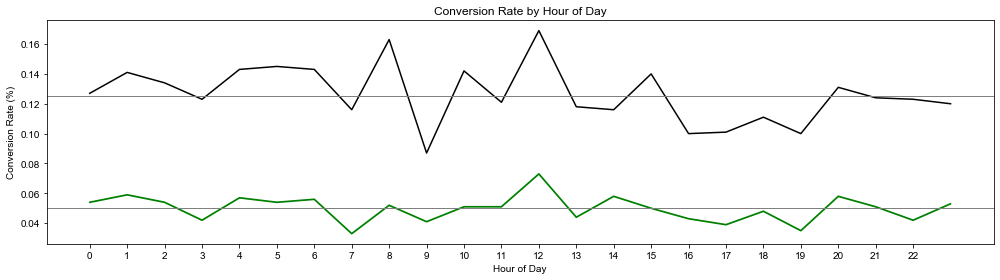

In [9]:
#Now merge datasets together
fb_install_hour = pd.merge(total_fb_installs_hour, total_fb_conv_hour, on='hour')
fb_view_others = pd.merge(total_fb_views_hour, fb_install_hour, on='hour')
fb_hour_full = pd.merge(fb_view_others, total_fb_trials_hour, on='hour' )

fb_hour_full['view-app(%)'] = round(((fb_hour_full['app_installs']/fb_hour_full['views'])*100),1)
fb_hour_full['app-trial(%)'] = round(((fb_hour_full['trial_start']/fb_hour_full['app_installs'])*100),1)
fb_hour_full['trial-conv(%)'] = round(((fb_hour_full['conversions']/fb_hour_full['trial_start'])*100),1)
fb_hour_full['view-trial(%)'] = round(((fb_hour_full['trial_start']/fb_hour_full['views'])*100),3)
fb_hour_full['view-conv(%)'] = round(((fb_hour_full['conversions']/fb_hour_full['views'])*100),3)
av_a_t = round((sum(fb_hour_full['trial_start'])/sum(fb_hour_full['app_installs'])*100),1)
av_v_t = round((sum(fb_hour_full['trial_start'])/sum(fb_hour_full['views'])*100),3)
av_v_c = round((sum(fb_hour_full['conversions'])/sum(fb_hour_full['views'])*100),3)

fb_hour_full = fb_hour_full[['hour','views','view-app(%)','view-trial(%)','view-conv(%)','app_installs','app-trial(%)','trial_start','trial-conv(%)','conversions']]

plt.figure(figsize=(14, 4))
plt.subplot(111)
plt.plot(fb_hour_full['hour'], fb_hour_full['view-trial(%)'], color ='black', linestyle='solid')
plt.style.use('seaborn')
plt.ylabel('Conversion Rate (%)')
plt.xlabel('Hour of Day')
plt.axhline(av_v_t, lw =1, label='Avg Rate', color='gray')
plt.xticks(np.arange(0, 23, step=1))
plt.title('Views to Trial Rate by Hour of Day')


plt.subplot(111)
plt.plot(fb_hour_full['hour'], fb_hour_full['view-conv(%)'], color ='green', linestyle='solid')
plt.style.use('seaborn')
plt.ylabel('Conversion Rate (%)')
plt.xlabel('Hour of Day')
plt.axhline(av_v_c, lw =1, label='Avg Rate', color='gray')
plt.xticks(np.arange(0, 23, step=1))
plt.title('Conversion Rate by Hour of Day')

plt.tight_layout()

`Black line: view to trial conversions
Green line: view to paid subscriber conversions`

The information above is interesting, let's take a look at the time we tend to accumulate views on our articles when advertising.

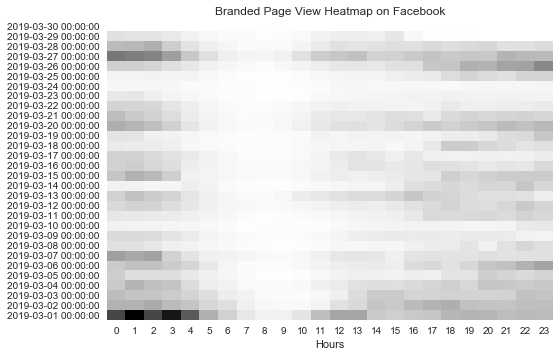

In [10]:
fb_views_heatmap = branded_only_fb.groupby(['view_date', 'view_hour'])['uid'].count().unstack(fill_value=0)
plt.pcolor(fb_views_heatmap)
plt.title("Branded Page View Heatmap on Facebook")
plt.xlabel("Hours")
plt.yticks(np.arange(0.5, len(fb_views_heatmap.index), 1), fb_views_heatmap.index)
plt.xticks(np.arange(0.5, len(fb_views_heatmap.columns), 1), fb_views_heatmap.columns)
plt.show()

In [63]:
fb_hour_full.head() #Remove ".head()" to view data in full

,hour,views,view-app(%),view-trial(%),view-conv(%),app_installs,app-trial(%),trial_start,trial-conv(%),conversions
0,0,139034,2.1,0.127,0.054,2946,6.0,177,42.4,75
1,1,143515,2.4,0.141,0.059,3403,5.9,202,42.1,85
2,2,132572,2.3,0.134,0.054,3067,5.8,177,40.7,72
3,3,114285,2.4,0.123,0.042,2709,5.2,141,34.0,48
4,4,85259,2.6,0.143,0.057,2209,5.5,122,40.2,49


#### A few thoughts:
Results are fairly volatile when assessing the conversion rate from `views` to `trial`. For example, we see the highest conversion rates at 8am and the lowest at 9am and these sharp spikes continue until 1pm. However looking at the green line, which signifies when paying subscribers have converted, we see a noticeable spike midday at 12pm, which we can recommend to our performance marketing manager to optimize on. 

Additionally, we have a heatmap on the day and hour people have viewed our ads. You can see that there is a bias towards very early in the morning and in the evening. It's a good job that from 7am-9am doesn't have much traffic, but we need to make sure the afternoon gets more activity.

##### Next Steps
* Recommend to Performance Marketing Manager that we advertise more during the afternoon, with a specific focus on 12pm.
* Compare how conversion rates differ from weekends and weekdays and see if that gives us a clearer picture on results.
* Consolidate the graph by rolling up the insights to `Early Morning`, `Morning`, `Afternoon`, `Evening`, and `Late Night`. 

_____________________________

## Daily Results

Next let's look into conversion data over the course of the month. Was there a time of the month that helped/hurt performance? If so, what was responsible for that? We'll analyze how the top half of the funnel has performed, as content plays the biggest role at that time. As a reminder, a typical `trial` takes about 7 days to convert, so we won't look too deeply what happens after someone signs up for a trial.

In [12]:
total_fb_views_day = branded_only_fb['view_date'].value_counts()
total_fb_views_day.sort_index(inplace=True)
total_fb_views_day = pd.DataFrame(data=total_fb_views_day)
total_fb_views_day['day']=total_fb_views_day.index
total_fb_views_day = total_fb_views_day.reset_index(drop=True)
total_fb_views_day['views']=total_fb_views_day['view_date']
total_fb_views_day = total_fb_views_day.drop(['view_date'],axis=1)

total_fb_installs_day = facebook_app['app_date'].value_counts()
total_fb_installs_day.sort_index(inplace=True)
total_fb_installs_day = pd.DataFrame(data=total_fb_installs_day)
total_fb_installs_day['day']=total_fb_installs_day.index
total_fb_installs_day = total_fb_installs_day.reset_index(drop=True)
total_fb_installs_day['app_installs'] = total_fb_installs_day['app_date']
total_fb_installs_day = total_fb_installs_day.drop(['app_date'], axis=1)
total_fb_installs_day.head(2)

# Breaking down by hour on the amount of Trial Starts
total_fb_trials_day = fb_app_checkout['app_date'].value_counts()
total_fb_trials_day.sort_index(inplace=True)
total_fb_trials_day = pd.DataFrame(data=total_fb_trials_day)
total_fb_trials_day['day']=total_fb_trials_day.index
total_fb_trials_day = total_fb_trials_day.reset_index(drop=True)
total_fb_trials_day['trial_start'] = total_fb_trials_day['app_date']
total_fb_trials_day = total_fb_trials_day.drop(['app_date'], axis=1)
total_fb_trials_day.head(2)

# Breaking down by hour on the amount of Conversions
total_fb_conv_day = fb_app_checkout_conv['checkout_date'].value_counts()
total_fb_conv_day.sort_index(inplace=True)
total_fb_conv_day = pd.DataFrame(data=total_fb_conv_day)
total_fb_conv_day['day']=total_fb_conv_day.index
total_fb_conv_day = total_fb_conv_day.reset_index(drop=True)
total_fb_conv_day['conversions'] = total_fb_conv_day['checkout_date']
total_fb_conv_day = total_fb_conv_day.drop(['checkout_date'], axis=1)

In [16]:
views_app_elasticity = round(((fb_day_full_clean['views-app(%)'].max() - fb_day_full_clean['views-app(%)'].min())/fb_day_full_clean['views-app(%)'].min())*100)
views_app_elasticity = str(views_app_elasticity)
app_trial_elasticity = round(((fb_day_full_clean['app-trial(%)'].max() - fb_day_full_clean['app-trial(%)'].min())/fb_day_full_clean['app-trial(%)'].min())*100)
app_trial_elasticity = str(app_trial_elasticity)
trial_conv_elasticity = round(((fb_day_full_clean['trial-conv(%)'].max() - fb_day_full_clean['trial-conv(%)'].min())/fb_day_full_clean['trial-conv(%)'].min())*100)
trial_conv_elasticity = str(trial_conv_elasticity)
day_t_c = round((sum(fb_day_full['conversions'])/sum(fb_day_full['trial_start'])*100),1)

In [15]:
#Now merge datasets together
fb_install_day = pd.merge(total_fb_installs_day, total_fb_conv_day, on='day')
fb_views_others = pd.merge(total_fb_views_day, fb_install_day, on='day')
fb_day_full = pd.merge(fb_views_others, total_fb_trials_day, on='day' )

fb_day_full['views-app(%)'] = round(((fb_day_full['app_installs']/fb_day_full['views'])*100),1)
fb_day_full['views-trial(%)'] = round(((fb_day_full['trial_start']/fb_day_full['views'])*100),2)
fb_day_full['app-trial(%)'] = round(((fb_day_full['trial_start']/fb_day_full['app_installs'])*100),1)
fb_day_full['trial-conv(%)'] = round(((fb_day_full['conversions']/fb_day_full['trial_start'])*100),2)
day_a_t = round((sum(fb_day_full['trial_start'])/sum(fb_day_full['app_installs'])*100),1)
day_v_t = round((sum(fb_day_full['trial_start'])/sum(fb_day_full['views'])*100),2)
day_t_c = round((sum(fb_day_full['conversions'])/sum(fb_day_full['trial_start'])*100),2)

fb_day_full = fb_day_full[['day','views','views-app(%)','views-trial(%)','app_installs','app-trial(%)','trial_start','trial-conv(%)','conversions']]
fb_day_full_clean = fb_day_full[fb_day_full['app_installs'] > 100]

C:\Users\Nitu\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Campaign Conversions per Day')

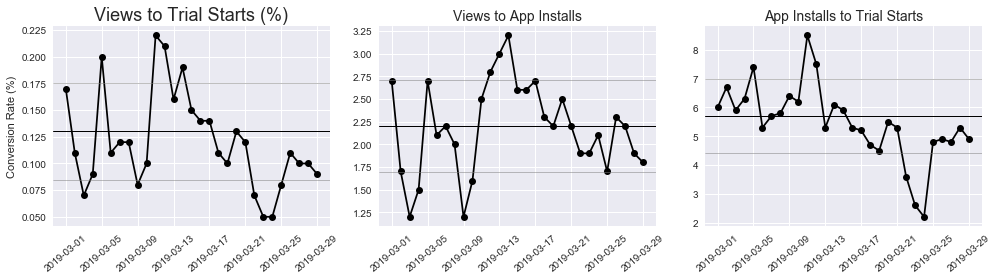

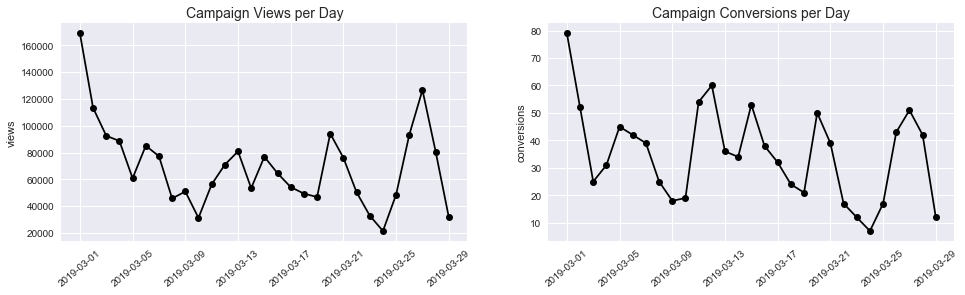

In [17]:
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot_date(fb_day_full_clean['day'], fb_day_full_clean['views-trial(%)'], color ='black', linestyle='solid')
plt.style.use('seaborn')
plt.ylabel('Conversion Rate (%)')
plt.xticks(rotation=40)
plt.axhline(day_v_t, lw =1, label='Avg Rate', color='black')
plt.axhline(day_v_t+0.045157, lw =.5, label='Avg Rate', color='gray')
plt.axhline(day_v_t-0.045157, lw =.5, label='Avg Rate', color='gray')
#plt.xticks(np.arange(0, 30, step=2))
plt.title('Views to Trial Starts (%)', fontdict = {'fontsize' : 18})

plt.subplot(132)
plt.plot_date(fb_day_full_clean['day'], fb_day_full_clean['views-app(%)'], color ='black', linestyle='solid')
plt.style.use('seaborn')
#plt.ylabel('Conversion Rate (%)')
plt.xticks(rotation=40)
day_v_a = round((sum(fb_day_full['app_installs'])/sum(fb_day_full['views'])*100),1)
plt.axhline(day_v_a, lw =1, label='Avg Rate', color='black')
plt.axhline(day_v_a+.5036, lw=.5, color='gray') #Standard deviation
plt.axhline(day_v_a-.5036, lw=.5, color='gray') #Standard deviation
#plt.xticks(np.arange(0, 30, step=2))
plt.title('Views to App Installs', fontdict = {'fontsize' : 14})

plt.subplot(133)
plt.plot_date(fb_day_full_clean['day'], fb_day_full_clean['app-trial(%)'], color ='black', linestyle='solid')
#plt.ylabel('Conversion Rate (%)')
plt.xticks(rotation=40)
plt.axhline(day_a_t, lw =1, label='Avg Rate', color='black')
plt.axhline(day_a_t+1.3, lw=.5, color='gray')
plt.axhline(day_a_t-1.3, lw=.5, color='gray')
#plt.xticks(np.arange(0, 30, step=2))
plt.title('App Installs to Trial Starts', fontdict = {'fontsize' : 14})
plt.tight_layout()

plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot_date(fb_day_full_clean['day'], fb_day_full_clean['views'], color='black', linestyle='solid')
plt.ylabel('views')
plt.xticks(rotation=40)
plt.title('Campaign Views per Day', fontdict = {'fontsize' : 14})

plt.subplot(122)
plt.plot_date(fb_day_full_clean['day'], fb_day_full_clean['conversions'], color='black', linestyle='solid')
plt.ylabel('conversions')
plt.xticks(rotation=40)
plt.title('Campaign Conversions per Day', fontdict = {'fontsize' : 14})

#### A few thoughts:
One particular area of concern that stands out is the volatility of `app installs` to `trial starts` (see: `March 11th` and `March 24th`). Possibly the article people were interested in before, wasn't enticing enough to have them start a trial? We'll look into that deeper before we take this to our product marketer. Below are some other findings that we can make out:

* **March 1st**

We had the highest amount of views on our articles and saw higher than average conversion rates. Most notably, the conversion rate from `views` to `app installs` was one full standard deviation higher than the average. Did we run ads prior to March 1st? If we didn't, possibly the installment of new ads and new content was enticing to a prospective user base. 

* **March 3rd & 9th**

Articles on those days performed very poorly on Facebook, our `views` to `app installs` conversion rate was at its lowest. What articles were in circulation? And how long have they been in circulation?

* **March 11th**

We saw a conversion rate above 8% from `app installs` to `trial starts` — our highest for the month. What were the articles that were being run on March 11th? Subscribers couldn't wait to sign up for a trial on that day. Possibly it Was the first time that the article came out? 

* **March 23rd - 24th**

It's interesting to note that the conversion rate for `app installs` to `trial starts` was unusually low for those days, by two standard deviations. Were the articles just not effective enough to have subscribers actually want to sign up for a trial? Was the product marketing team testing something new that day? Did the app experience some downtime that may have affected results?

###### Next Steps
* Check in with the performance marketing team and see if we ran advertisements in February.
* For high-performance days, check to see how long the articles have been in circulation, were they new? 
* Get in touch with product marketing and figure out just why we had such low `app installs` to `trial starts` conversion rates from `March 22nd to March 24th`. 
* The `branded_content_events` dataset only includes authors in the `campaign_name` column and not the `article_id`. That means we aren't able to pinpoint the number of impressions that an article gets; authors write multiple articles so even though we do have a good idea of what the articles are, we can't be totally sure. For example, this is all we can see for March 11th (high conversion day) compared to March 24th (low conversion day):

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

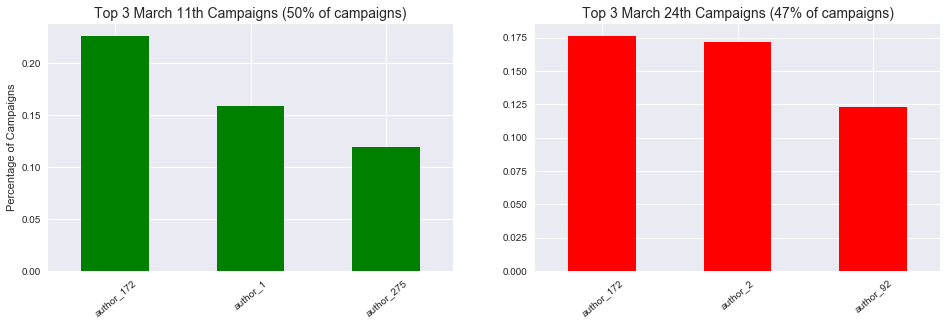

In [18]:
plt.figure(figsize=(16, 10))

plt.subplot(221)
mar_11 = branded_only_fb[branded_only_fb['view_date']=='2019-03-11']
mar11=mar_11['campaign_name'].value_counts(normalize=True).head(3)
mar11.plot.bar(facecolor='green')
plt.xticks(rotation=40)
plt.title('Top 3 March 11th Campaigns (50% of campaigns)',fontdict = {'fontsize' : 14})
#plt.axhline(5.66, color='black') #Average conversion rate
plt.ylabel('Percentage of Campaigns')
plt.subplot(222)
mar_24 = branded_only_fb[branded_only_fb['view_date']=='2019-03-24']
mar24=mar_24['campaign_name'].value_counts(normalize=True).head(3)
mar24.plot.bar(facecolor='r')
plt.title('Top 3 March 24th Campaigns (47% of campaigns)',fontdict = {'fontsize' : 14})
plt.xticks(rotation=40)

The top campaign in circulation on Facebook for our best day and worst day was by `author_172`! 

In [19]:
fb_ba = pd.merge(branded_only_fb, facebook_app, on='uid')
auth172 = fb_ba[(fb_ba['campaign_name'] =='author_172')]
print('% of articles by author_172 that were app installs from Facebook:')
print(auth172['article_id'].value_counts(normalize=True).head(3))

% of articles by author_172 that were app installs from Facebook:
4382.0    0.918803
4656.0    0.019943
5335.0    0.017094
Name: article_id, dtype: float64


Although we can pull up the information for each specific day and how much these articles led to app installs, we still don't have `article_id` data  in `branded`.

_________________________

## Assessing Customer Acquisition by Day of the Week

In [20]:
fb_day_full['DayOfWeek'] = fb_day_full['day'].dt.day_name()
fb_day_full_clean['DayOfWeek'] = fb_day_full_clean['day'].dt.day_name()
fb_day_full.head()

C:\Users\Nitu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,day,views,views-app(%),views-trial(%),app_installs,app-trial(%),trial_start,trial-conv(%),conversions,DayOfWeek
0,2019-03-01,168922,2.7,0.17,4630,6.0,279,28.32,79,Friday
1,2019-03-02,113324,1.7,0.11,1934,6.7,129,40.31,52,Saturday
2,2019-03-03,92514,1.2,0.07,1118,5.9,66,37.88,25,Sunday
3,2019-03-04,88576,1.5,0.09,1292,6.3,81,38.27,31,Monday
4,2019-03-05,60804,2.7,0.20,1658,7.4,122,36.89,45,Tuesday


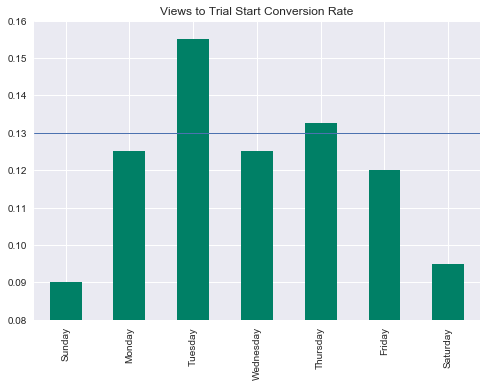

In [53]:
day = pd.pivot_table(fb_day_full_clean, index='DayOfWeek', values='views-app(%)',aggfunc='mean')
day= day.iloc[[3,1,5,6,4,0,2]]
avg = round((sum(fb_day_full_clean['app_installs'])/sum(fb_day_full_clean['views'])*100),2)
avg_vt = round((sum(fb_day_full_clean['trial_start'])/sum(fb_day_full_clean['views'])*100),2)

day_2 = pd.pivot_table(fb_day_full_clean, index='DayOfWeek', values='views-trial(%)',aggfunc='mean')
day_2= day_2.iloc[[3,1,5,6,4,0,2]]

#print("The average conversion rate from Branded to App Installs was " + str(avg) + "%.")
day_2.plot(kind='bar',  ylim=(.08,.16), legend = False, title = 'Views to Trial Start Conversion Rate',colormap='summer')
plt.xlabel('')
plt.axhline(avg_vt, lw =1, label='Avg Rate')

#### A Few Thoughts

As the chart shows, weekdays are the best days for us to advertise while placing a focus on Tuesday specifically. People are less likely to sign up for a trial on weekends.

-------------------------------------

# Article & Campaign Performance

Since we are advertising based on the articles we publish, it's worth identifying which articles/authors are driving the greatest impact to the results that we are seeing above. We'll set up a table to help us identify top/bottom performing articles/authors and we can send the report out to our content team...

**Article code setup**

`article_id` shows up in the `app_install_events` and `checkout_events` datasets. We will set up a table similar to how we have the above funnel to see what articles are helping/hurting our cause.

In [23]:
#Article total app installs - 44857 total
art_app = facebook_app['article_id'].value_counts()
art_app = pd.DataFrame(data=art_app)
art_app['app_installs']=art_app['article_id']
art_app = art_app.drop(['article_id'],axis=1)
art_app['article_id']=art_app.index
art_app = art_app.reset_index(drop=True)
art_app = art_app[['article_id','app_installs']]
art_app.head()

#Article Trials - 2538 total - 5.66%
art_trial = fb_app_checkout['article_id'].value_counts()
art_trial = pd.DataFrame(data=art_trial)
art_trial['trials']=art_trial['article_id']
art_trial = art_trial.drop(['article_id'],axis=1)
art_trial['article_id']=art_trial.index
art_trial = art_trial.reset_index(drop=True)
art_trial = art_trial[['article_id','trials']]
art_trial.head()

#Conversions - 1019 total - 40.15%
art_conv = fb_app_checkout_conv['article_id'].value_counts()
art_conv = pd.DataFrame(data=art_conv)
art_conv['conversions']=art_conv['article_id']
art_conv = art_conv.drop(['article_id'],axis=1)
art_conv['article_id']=art_conv.index
art_conv = art_conv.reset_index(drop=True)
art_conv = art_conv[['article_id','conversions']]

#Merge files together, we'll be focusing on art_a_t (articles from apps to trials)
art_a_t = pd.merge(art_app, art_trial, on='article_id', how='left')
art_full = pd.merge(art_a_t, art_conv, on='article_id', how='left')
art_full = art_full.fillna(0)
art_a_t = art_a_t.fillna(0)
art_a_t['trials'] = art_a_t['trials'].astype(int)
art_full['trials'] = art_full['trials'].astype(int)
art_full['conversions'] = art_full['conversions'].astype(int)

#Adding conversion metrics
art_a_t['conv'] = round(((art_a_t['trials']/art_a_t['app_installs'])*100),1)
art_full['a-t(%)'] = round(((art_full['trials']/art_full['app_installs'])*100),1)
art_full['t-c(%)'] = round(((art_full['conversions']/art_full['trials'])*100),1)
art_full['a-c(%)'] = round(((art_full['conversions']/art_full['app_installs'])*100),1)
art_full = art_full[['article_id','app_installs','a-t(%)','a-c(%)','trials','t-c(%)','conversions']]
avg_a_t = round((sum(art_full['trials'])/sum(art_full['app_installs'])*100),2)

# Add p-value column
from scipy.stats import chisquare
import numpy as np

avg_rate= .0566 #Assuming a 5.66% conversion rate

pvalues = []
for index, row in art_a_t.iterrows():
    first_o = row['trials']
    second_o = row['app_installs']
    observed = [first_o, second_o]
    expected = [sum(observed)*.0566, sum(observed)*(1-.0566)]
    chisquare_value, result_pvalue = chisquare(observed, expected)
    result_pvalue = round((result_pvalue*100),2)
    pvalues.append(result_pvalue)

art_a_t['pvalue'] = pvalues
art_a_t['lowerthan5'] = art_a_t['pvalue'] < 5.01

art_a_t['article_id'] = art_a_t['article_id'].astype(str)
high_perf_art_ss = art_a_t[(art_a_t['lowerthan5'] == True) & (art_a_t['conv'] > 5.66) & (art_a_t['trials'] > 4)]
low_perf_art_ss = art_a_t[(art_a_t['lowerthan5'] == True) & (art_a_t['conv'] < 5.66) & (art_a_t['trials'] > 4)]
art_full.head()

,article_id,app_installs,a-t(%),a-c(%),trials,t-c(%),conversions
0,3172.0,9434,6.1,2.1,578,34.6,200
1,3505.0,3261,6.4,2.3,209,35.9,75
2,5335.0,1771,5.2,2.2,92,42.4,39
3,5077.0,1755,4.0,2.0,71,49.3,35
4,3320.0,1153,4.4,1.3,51,29.4,15


#### Campaign Code Setup

`campaign_name` shows up in the `branded_content_events` dataset. With the merge, we are able to see how certain authors perform through the funnel as well. Since we have much more data from this side, you'll see that we are able to get more statistically significant results in our findings.

In [24]:
#Campaign Views
campaign_views = branded_only_fb['campaign_name'].value_counts()
campaign_views = pd.DataFrame(data=campaign_views)
campaign_views['views']=campaign_views['campaign_name']
campaign_views = campaign_views.drop(['campaign_name'],axis=1)
campaign_views['campaign_name']=campaign_views.index
campaign_views = campaign_views.reset_index(drop=True)
campaign_views = campaign_views[['campaign_name','views']]
campaign_views.head()

#Campaign App installs - 64867 total
fb_brand_app = pd.merge(branded_only_fb, facebook_app, on='uid')
campaign_app = fb_brand_app['campaign_name'].value_counts()
campaign_app = pd.DataFrame(data=campaign_app)
campaign_app['app_installs']=campaign_app['campaign_name']
campaign_app = campaign_app.drop(['campaign_name'],axis=1)
campaign_app['campaign_name']=campaign_app.index
campaign_app = campaign_app.reset_index(drop=True)
campaign_app = campaign_app[['campaign_name','app_installs']]
campaign_app.head()

#Campaign Trials - 3610 total - 5.56%
fb_bac = pd.merge(fb_brand_app, checkout, on='device_id')
campaign_trial = fb_bac['campaign_name'].value_counts()
campaign_trial = pd.DataFrame(data=campaign_trial)
campaign_trial['trials']=campaign_trial['campaign_name']
campaign_trial = campaign_trial.drop(['campaign_name'],axis=1)
campaign_trial['campaign_name']=campaign_trial.index
campaign_trial = campaign_trial.reset_index(drop=True)
campaign_trial = campaign_trial[['campaign_name','trials']]
campaign_trial.head()

#Campaign Conversions - 1472 total - 40.78%
conv_fb_bac = fb_bac[fb_bac['conversion'] == True]
campaign_conv = conv_fb_bac['campaign_name'].value_counts()
campaign_conv = pd.DataFrame(data=campaign_conv)
campaign_conv['conversions']=campaign_conv['campaign_name']
campaign_conv = campaign_conv.drop(['campaign_name'],axis=1)
campaign_conv['campaign_name']=campaign_conv.index
campaign_conv = campaign_conv.reset_index(drop=True)
campaign_conv = campaign_conv[['campaign_name','conversions']]
campaign_conv.head()

#Merge files together, we'll be focusing on art_a_t (articles from apps to trials)
camp_v_t = pd.merge(campaign_views, campaign_trial, on='campaign_name', how='left')
camp_va = pd.merge(campaign_views, campaign_app, on='campaign_name', how='left')
camp_vat = pd.merge(camp_va, campaign_trial, on='campaign_name', how='left')
camp_a_t = pd.merge(campaign_app, campaign_trial, on='campaign_name', how='left')
#camp_full = pd.merge(camp_a_t, campaign_conv, on='campaign_name', how='left')
camp_full = pd.merge(camp_vat, campaign_conv, on='campaign_name', how='left') #Updated to include views

camp_v_t = camp_v_t.fillna(0)
camp_full = camp_full.fillna(0)
camp_a_t = camp_a_t.fillna(0)
camp_v_t['trials'] = camp_v_t['trials'].astype(int)
camp_a_t['trials'] = camp_a_t['trials'].astype(int)
camp_full['app_installs'] = camp_full['app_installs'].astype(int)
camp_full['trials'] = camp_full['trials'].astype(int)
camp_full['conversions'] = camp_full['conversions'].astype(int)

#Adding conversion metrics
camp_a_t['conv'] = round(((camp_a_t['trials']/camp_a_t['app_installs'])*100),1)
camp_v_t['conv'] = round(((camp_v_t['trials']/camp_v_t['views'])*100),2)
camp_full['v-a(%)'] = round(((camp_full['app_installs']/camp_full['views'])*100),1)
camp_full['a-t(%)'] = round(((camp_full['trials']/camp_full['app_installs'])*100),1)
camp_full['t-c(%)'] = round(((camp_full['conversions']/camp_full['trials'])*100),1)
#camp_full['a-c(%)'] = round(((camp_full['conversions']/camp_full['app_installs'])*100),1)
camp_full['v-c(%)'] = round(((camp_full['conversions']/camp_full['views'])*100),2)
camp_full = camp_full[['campaign_name','views','v-c(%)','v-a(%)', 'app_installs','a-t(%)','trials','t-c(%)','conversions']]

avgcamp_v_a = round((sum(camp_full['app_installs'])/sum(camp_full['views'])*100),2)
avgcamp_v_c = round((sum(camp_full['conversions'])/sum(camp_full['views'])*100),2)
avgcamp_a_t = round((sum(camp_full['trials'])/sum(camp_full['app_installs'])*100),2)
avgcamp_v_t = round((sum(camp_v_t['trials'])/sum(camp_v_t['views'])*100),2) # =.18%
#print("Average Conversion Rate from 'App Installs to Trials':")
#print(str(avgcamp_a_t) + '%')
#author_275 is the real deal

#Assuming a 5.57% conversion rate
avg_rate= .0557

#Add pvalue column for camp_a_t
pvalues_camp = []
for index, row in camp_a_t.iterrows():
    first_o = row['trials']
    second_o = row['app_installs']
    observed = [first_o, second_o]
    expected = [sum(observed)*.0557, sum(observed)*(1-.0557)]
    chisquare_value, result_pvalue = chisquare(observed, expected)
    result_pvalue = round((result_pvalue*100),2)
    pvalues_camp.append(result_pvalue)

camp_a_t['pvalue'] = pvalues_camp
camp_a_t['lowerthan5'] = camp_a_t['pvalue'] < 5.01

high_perf_camp_ss = camp_a_t[(camp_a_t['lowerthan5'] == True) & (camp_a_t['conv'] > 5.66) & (camp_a_t['trials'] > 4)]
low_perf_camp_ss = camp_a_t[(camp_a_t['lowerthan5'] == True) & (camp_a_t['conv'] < 5.66)]

#Add pvalue column for camp_v_t
pvalues_campaign = []
for index, row in camp_v_t.iterrows():
    first_o = row['trials']
    second_o = row['views']
    observed = [first_o, second_o]
    expected = [sum(observed)*.0018, sum(observed)*(1-.0018)]
    chisquare_value, result_pvalue = chisquare(observed, expected)
    result_pvalue = round((result_pvalue*100),2)
    pvalues_campaign.append(result_pvalue)

camp_v_t['pvalue'] = pvalues_campaign
camp_v_t['lowerthan5'] = camp_v_t['pvalue'] < 5.01

high_perf_camp_ss_vt = camp_v_t[(camp_v_t['lowerthan5'] == True) & (camp_v_t['conv'] > .18) & (camp_v_t['trials'] > 5)]
low_perf_camp_ss_vt = camp_v_t[(camp_v_t['lowerthan5'] == True) & (camp_v_t['conv'] < .18)]

print("Percentage of Campaigns that are Statistically Significant:")
print((len(low_perf_camp_ss_vt) + len(high_perf_camp_ss_vt))/len(camp_v_t))
camp_full.head()

Percentage of Campaigns that are Statistically Significant:
0.18149466192170818


,campaign_name,views,v-c(%),v-a(%),app_installs,a-t(%),trials,t-c(%),conversions
0,author_88,297689,0.10,4.5,13408,6.1,815,34.7,283
1,author_80,211559,0.03,1.9,4046,4.8,195,35.9,70
2,author_192,119259,0.00,0.0,1,0.0,0,NaN,0
3,author_35,69443,0.17,6.7,4682,6.2,288,40.3,116
4,author_266,58061,0.01,0.2,96,7.3,7,57.1,4


## Articles and Campaign Performance Analysis

When it comes to articles, we aren't able to gain perspective on `article_id` impressions as that information is not included in the branded dataset. That means we'll have to settle with `campaign_name` for most of our analysis as we are able to go through the full funnel: Branded -> App Install -> Trial Start -> Conversion. 

The graphs below are based on subscribers starting a free trial with our app as opposed to just installing the app. The reasoning behind this is if someone felt compelled to read an article, they would go through the added obstacle of signing up for a free trial to be able to read the article. 

### High Performing Articles & Campaigns

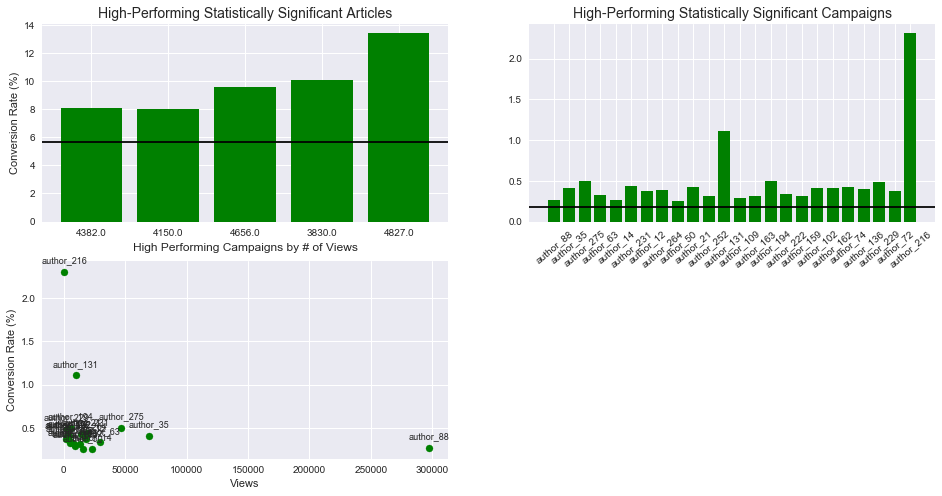

<Figure size 576x396 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')
plt.figure(figsize=(16, 8))

plt.subplot(221)
plt.bar(high_perf_art_ss['article_id'], high_perf_art_ss['conv'], facecolor='g')
plt.title('High-Performing Statistically Significant Articles',fontdict = {'fontsize' : 14})
plt.axhline(5.66, color='black') #Average conversion rate
plt.ylabel('Conversion Rate (%)')
plt.subplot(222)
plt.bar(high_perf_camp_ss_vt['campaign_name'], high_perf_camp_ss_vt['conv'], facecolor='g')
plt.title('High-Performing Statistically Significant Campaigns',fontdict = {'fontsize' : 14})
plt.axhline(.18, color='black') #Average conversion rate
plt.xticks(rotation=40)

plt.subplot(223) #Scatter plot that shows the number of campaigns
high_campaign_ids = []
high_camp_x = []
high_camp_y = []
for index, row in high_perf_camp_ss_vt.iterrows():
    camp_id = row['campaign_name']
    views = row['views']
    conv = row['conv']
    high_campaign_ids.append(camp_id)
    high_camp_x.append(views)
    high_camp_y.append(conv)
    
for i,type in enumerate(high_campaign_ids):
    x = high_camp_x[i]
    y = high_camp_y[i]
    plt.scatter(x, y, marker='o', color='green')
    plt.text(x+0.01, y+0.1, type, fontsize=9, horizontalalignment='center')
plt.title('High Performing Campaigns by # of Views', pad=10)
plt.xlabel('Views')
plt.ylabel("Conversion Rate (%)")
plt.show()

plt.tight_layout()

##### About the Graphs

* Top left: The `article_id` articles that perform better than the average rate of 5.66% from an app install to a trial start at a 95% P-value.
* Top right: The `campaign_name` campaigns that perform better than the average rate of .18% from a view to a trial start at a 95% P-value.
* Bottom left: Scatter plot of high-performing campaigns, `campaign_name`, where the x-axis is the number of views a campaign has received and the y-axis is the conversion rate from views to trial starts.

The reason why we only have 5 articles as opposed to 24 campaigns is because of sample size. Since we can rely on view data for `campaign_name`, we have much more of a sample size to work with and thus getting more campaigns to reach statistical significance. 

The scatter plot is a bit hard to read, but that's okay. The main use for it is to spot campaigns that stand out. For example, we should be investigating whether "`author_216`" or "`author_131`" are receiving an adequate amount of impressions. We don't have that information, however the next time we dig into this research, that would be information worth getting. 

### Low Performing Articles & Campaigns

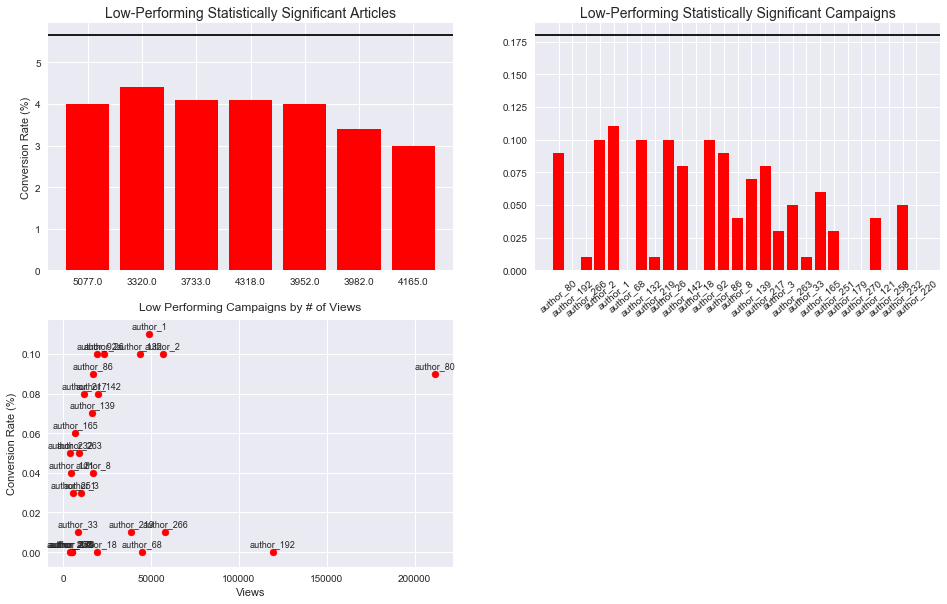

<Figure size 576x396 with 0 Axes>

In [26]:
plt.figure(figsize=(16, 10))

plt.subplot(221)
plt.bar(low_perf_art_ss['article_id'], low_perf_art_ss['conv'], facecolor='r')
plt.title('Low-Performing Statistically Significant Articles',fontdict = {'fontsize' : 14})
plt.axhline(5.66, color='black') #Average conversion rate
plt.ylabel('Conversion Rate (%)')
plt.subplot(222)
plt.bar(low_perf_camp_ss_vt['campaign_name'], low_perf_camp_ss_vt['conv'], facecolor='r')
plt.title('Low-Performing Statistically Significant Campaigns',fontdict = {'fontsize' : 14})
plt.axhline(.18, color='black') #Average conversion rate
plt.xticks(rotation=40)

plt.subplot(223) #Scatter plot that shows the number of campaigns
low_campaign_ids = []
low_camp_x = []
low_camp_y = []
for index, row in low_perf_camp_ss_vt.iterrows():
    camp_id = row['campaign_name']
    views = row['views']
    conv = row['conv']
    low_campaign_ids.append(camp_id)
    low_camp_x.append(views)
    low_camp_y.append(conv)
    
for i,type in enumerate(low_campaign_ids):
    x = low_camp_x[i]
    y = low_camp_y[i]
    plt.scatter(x, y, marker='o', color='red')
    plt.text(x+0.01, y+0.003, type, fontsize=9, horizontalalignment='center')
plt.title('Low Performing Campaigns by # of Views', pad=10)
plt.xlabel('Views')
plt.ylabel("Conversion Rate (%)")
plt.show()


plt.tight_layout()

##### About the Graphs

* Top left: The articles, `article_id`, that perform worse than the average rate of 5.66% from an app install to a trial start at a 95% P-value.
* Top right: The campaigns, `campaign_name`, that perform worse than the average rate of .18% from a view to a trial start at a 95% P-value.
* Bottom left: Scatter plot of low-performing campaigns, `campaign_name`, where the x-axis is the number of views a campaign has received and the y-axis is the conversion rate from views to trial starts.

These articles here have had a lot of opportunity to see results, but they are just not converting and are costing money in the long run. For example, articles under "author_192" have yet to see a single conversion after more than 100,000 views! My suggestion would be to stop advertising these articles immediately and get a new batch to throw in for testing, while understanding why these articles are not resonating when it comes to advertising.

##### Conclusion
Unfortunately we just do not have further information on the context behind these articles and campaigns as that will help carry us throughout the rest of our analysis and making deeper more insightful recommendations to our team. However this doesn't mean that we should stop our analysis just because we don't have all of the information we need. We still have a few variables based on day and time that we can evaluate to help us understand our audience base further. 

#### Next Steps

* Deliver these findings to our content team to help them shape future articles that will drive conversions. 
* Send the statistically significant `article_id` articles and `campaign_name` campaigns over to the performance marketing manager so they can optimize their ads. 
* Get in touch with data science to figure out how we can get more context behind the articles/campaigns so that we can make more step-level insights for the content team. 

### Housekeeping 1: Facebook vs. Organic

It's a bit of a stretch to compare Facebook to Organic as user intent is different between the two. With Facebook, we are looking to persuade an audience. With organic, people are searching for content like ours, so there is a bit more intent when it comes to the user base. However it is a good practice to take a look. 

In [27]:
fb_direct_purchase = len(fb_app_checkout[fb_app_checkout['checkout_status']=='direct_purchase'])
org_direct_purchase = len(org_app_checkout[org_app_checkout['checkout_status']=='direct_purchase'])
installs_facebook = len(facebook_app['device_id'].value_counts(dropna=False))
installs_organic = len(organic_app['device_id'].value_counts(dropna=False))
fb_dp_cv=round((fb_direct_purchase/installs_facebook)*100,2)
org_dp_cv=round((org_direct_purchase/installs_organic)*100,2)
org_uplift = round((((org_dp_cv - fb_dp_cv)/org_dp_cv)*100),2)

print('FACEBOOK:')
print('Total unique installs: '+str(installs_facebook))
print('Total direct purchase downloads: '+str(fb_direct_purchase))
print('Direct purchase conversion rate: '+str(fb_dp_cv)+'%')
print()
print('ORGANIC:')
print('Total unique installs: '+str(installs_organic))
print('Total direct purchase downloads: '+str(org_direct_purchase))
print('Direct purchase conversion rate: '+str(org_dp_cv)+'%')
print('% Uplift over Facebook: '+str(org_uplift)+'%')
print()
from scipy.stats import chisquare
import numpy as np
#Combining both Facebook and Organic Metrics and measure whether the results are SS in Facebook's case  
observed = np.array([53, 44775])
expected = np.array([106.5, 44721.5])

chisquare_value, result_pvalue = chisquare(observed, expected)
print('P-Value of Direct purchases from Facebook Ads:')
print(result_pvalue*100)

FACEBOOK:
Total unique installs: 44828
Total direct purchase downloads: 53
Direct purchase conversion rate: 0.12%

ORGANIC:
Total unique installs: 98249
Total direct purchase downloads: 287
Direct purchase conversion rate: 0.29%
% Uplift over Facebook: 58.62%

P-Value of Direct purchases from Facebook Ads:
2.0991486167128222e-05


### Housekeeping 2: Direct Purchases vs. Trials

In [28]:
print('Percentage of conversions that have come from trial_started vs. direct_purchase:')
print(fb_app_checkout_conv['checkout_status'].value_counts(normalize=True))

Percentage of conversions that have come from trial_started vs. direct_purchase:
trial_started      0.947988
direct_purchase    0.052012
Name: checkout_status, dtype: float64


### Housekeeping 3: iPhone vs. Android

In [44]:
iphone_full = full_merge[full_merge['platform']=='iPhone']
android_full = full_merge[full_merge['platform']!='iPhone']
iphone = branded[branded['platform'] == 'iPhone']
android = branded[branded['platform'] != 'iPhone']

print('iPhone Conversion Rate:')
print(round(len(iphone_full)/len(iphone),5))
print('Android Conversion Rate:')
print(round(len(android_full)/len(android),5))

iPhone Conversion Rate:
0.00217
Android Conversion Rate:
0.00098


## Conclusion

Throughout this analysis, we found out how content has performed, which days of the week performs the best, and factors that affects conversion rates. Additionally, we get an idea of how the acquisition funnel has looked for the month of March. 

In order to deliver more actionable insights, it's imperative as a marketing analyst to be able to get more information to get deeper:
* Having context behind the articles. It could be whether it is an advice piece, news reporting, or anything else. This will help optimize our campaigns much further to see what resonates the most with the Facebook audience.
* Include article_id in our branded data set.
* Receiving ad campaign info on Facebook. Facebook campaigns can be rather messy, and it's tough for performance marketers to glean summarized insights. Being able to get this information can help them make large scale changes to their campaigns. 

#### Key Insights Found for Performance Marketing Managers & Product Marketing Managers:
* iPhone users start trials at a rate that's more than double than Android users
* 95% of subscribers that have converted come from trials as opposed to a direct purchase
* We see a 20% increase in trials when advertising on a Tuesday and a -28% decrease in conversions when advertising on weekends.
* We see a 37.6% boost in conversions at 12pm, yet we only advertise at noon only 3.4% of the time.
* We spotted 3 dates that were outliers when analyzing the conversion rates for 'App Installs to Trial Starts' (March 11th, March 23rd and March 24th). I would imagine that it would be one of the more stable metrics.
* Author_192's articles have had well over 100,000 views yet have not reached a single conversion.
* Author_216 and Author_131 have conversion rates over 1% yet both have well under 25,000 views. See if we can continue to push these articles out.